In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def find_global_average_TLS(calendar_TLS_maps):
    lats = np.arange(-88.75, 88.76, 2.5)
    weights = np.swapaxes(np.broadcast_to(np.cos(np.deg2rad(lats)), (144,72)), 0,1)
    TLS_calendar = []
    for year_of_data in calendar_TLS_maps:
        TLS_by_year = []
        for month_of_data in year_of_data:
            nan_binary_map = np.divide(month_of_data, month_of_data)
            weighted_TLS_map = np.multiply(weights, month_of_data)
            weighted_binary_map = np.multiply(weights, nan_binary_map)
            average_TLS = np.nansum(weighted_TLS_map)/np.nansum(weighted_binary_map)
            TLS_by_year.append(average_TLS)
        TLS_calendar.append(TLS_by_year)
    return(np.array(TLS_calendar))

def trend_finder(time_series):
    months = np.linspace(0,len(time_series),len(time_series))
    months_nonnan = months[~np.isnan(time_series)]
    time_series_nonan = time_series[~np.isnan(time_series)]
    slope, intercept = stats.linregress(months_nonnan, time_series_nonan)[:2]
    best_fit = intercept + slope*months_nonnan
    decadal_trend = slope*12*10
    error = time_series_nonan - best_fit
    N = len(time_series_nonan)
    r_autocorrelation = stats.pearsonr(time_series_nonan[:-1], time_series_nonan[1:])[0]
    Neff = N * ((1 - r_autocorrelation)/(1 + r_autocorrelation))
    standard_error_squared = (1/(Neff -2))*np.sum(error**2)
    standard_error_x2 = standard_error_squared*2
    
    return(str(decadal_trend)[:6], str(standard_error_x2)[:6])

def Prof_trend_finder(time_series_map):
    months = np.linspace(0,len(time_series_map),len(time_series_map))
    trend_map = []
    for lat in range(0, len(time_series_map[0])):
        lat_row = []
        for height in range(0, len(time_series_map[0,0])):
            time_series = time_series_map[:,lat,height]
            months_nonnan = months[~np.isnan(time_series)]
            time_series_nonan = time_series[~np.isnan(time_series)]
            slope, intercept = stats.linregress(months_nonnan, time_series_nonan)[:2]
            best_fit = intercept + slope*months_nonnan
            decadal_trend = slope*12*10
            error = time_series_nonan - best_fit
            N = len(time_series_nonan)
            r_autocorrelation = stats.pearsonr(time_series_nonan[:-1], time_series_nonan[1:])[0]
            Neff = N * ((1 - r_autocorrelation)/(1 + r_autocorrelation))
            standard_error_squared = (1/(Neff -2))*np.sum(error**2)
            standard_error_x2 = standard_error_squared*2
            lat_row.append([decadal_trend, standard_error_x2])
        trend_map.append(lat_row)
    trend_map = np.array(trend_map)
    return(trend_map)

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Years')

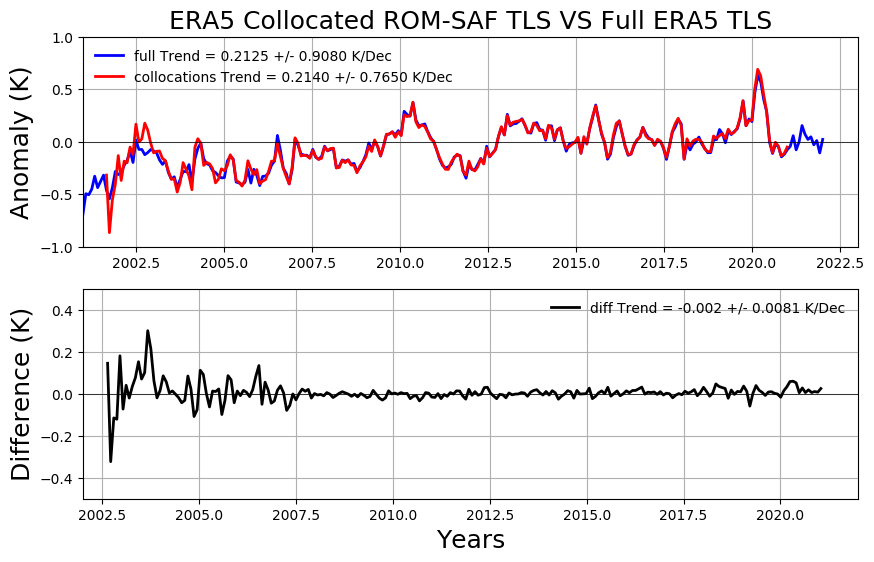

In [2]:
ERA5collocationsGPS = np.load('/home/bdc2/aodhan/ROM_SAF/TLS_MonthlyMeanMaps/TLSERA5collocationsGPS_2001_2022.npy')
ERA5collocationsGPSAnomalies = ERA5collocationsGPS - np.nanmean(ERA5collocationsGPS[7:17], axis=0)
ERA5full = np.load('/home/bdc2/aodhan/ROM_SAF/TLS_MonthlyMeanMaps/ERA5TLSMaps_Jan2001_Dec2021.npy')
ERA5fullAnomalies = ERA5full - np.nanmean(ERA5full[7:17], axis=0)
ERA5collocationsGPSAnomaliesCalendar_GM = find_global_average_TLS(ERA5collocationsGPSAnomalies)
ERA5fullAnomaliesCalendar_GM = find_global_average_TLS(ERA5fullAnomalies)

ERA5collocations_GM_ts = np.reshape(ERA5collocationsGPSAnomaliesCalendar_GM, (22*12))
ERA5full_GM_ts = np.reshape(ERA5fullAnomaliesCalendar_GM, (21*12))
difference_ts = ERA5collocations_GM_ts[:-12] - ERA5full_GM_ts

collocations_slope, collocations_CI = trend_finder(ERA5collocations_GM_ts)
full_slope, full_CI = trend_finder(ERA5full_GM_ts)
diff_slope, diff_CI = trend_finder(difference_ts)

fig, axs = plt.subplots(2,1,figsize=(10,6))

axs[0].plot(np.linspace(2001, 2022, 21*12), ERA5full_GM_ts, color='blue', linewidth=2, label=('full Trend = ' + full_slope + ' +/- ' + full_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2001, 2023, 22*12), ERA5collocations_GM_ts, color='red', linewidth=2, label=('collocations Trend = ' + collocations_slope + ' +/- ' + collocations_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2001, 2023, 22*12), np.zeros(len(ERA5collocations_GM_ts)), color='black', linewidth=0.5)
axs[0].set_ylim(-1,1)
axs[0].set_xlim(2001,2023)
axs[0].legend(frameon=False)
axs[0].grid()

axs[1].plot(np.linspace(2002, 2022, 21*12), difference_ts, color='black', linewidth=2, label=('diff Trend = ' + diff_slope + ' +/- ' + diff_CI + ' K/Dec' ))
axs[1].legend(frameon=False)
axs[1].set_ylim(-.5,.5)
axs[1].plot(np.linspace(2002, 2022, 21*12), np.zeros(len(difference_ts)), color='black', linewidth=0.5)
axs[1].set_xlim(2002,2022)
axs[1].grid()

axs[0].set_title('ERA5 Collocated ROM-SAF TLS VS Full ERA5 TLS', fontsize=18)
axs[0].set_ylabel('Anomaly (K)', fontsize=18)
axs[1].set_ylabel('Difference (K)', fontsize=18)
axs[1].set_xlabel('Years', fontsize=18)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


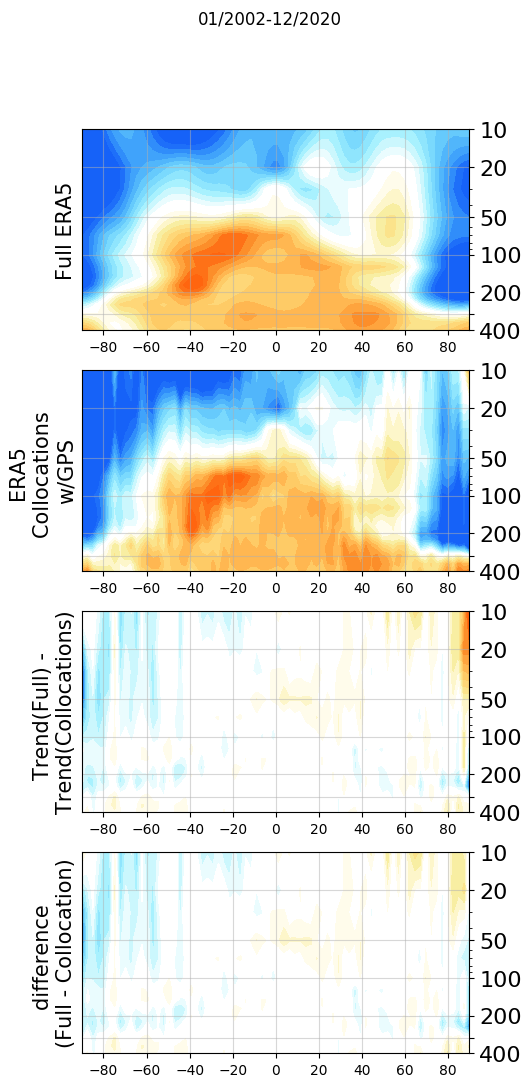

In [10]:
# Fix data to only take trend over 2002 - 2020 time period
ERA5collocationsGPS = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ProfERA5collocationsGPS_2001_2022.npy')[1:-2]
ERA5collocationsGPSAnomalies = ERA5collocationsGPS - np.nanmean(ERA5collocationsGPS[6:16], axis=0)
ERA5collocationsGPSAnomalies_zm = np.nanmean(ERA5collocationsGPSAnomalies, axis=3)
ERA5collocationsGPSAnomalies_zm_ts = np.reshape(ERA5collocationsGPSAnomalies_zm, (19*12,72,19))
ERA5full = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ERA5ProfMaps_Jan2001_Dec2021.npy')[1:-1]
ERA5full = np.flip(ERA5full, axis=3)
ERA5fullAnomalies = ERA5full - np.nanmean(ERA5full[6:16], axis=0)
ERA5fullAnomalies_zm = np.nanmean(ERA5fullAnomalies, 4)
ERA5fullAnomalies_zm_ts = np.swapaxes(np.reshape(ERA5fullAnomalies_zm, (19*12,19,72)),1,2)
difference_ts = ERA5collocationsGPSAnomalies_zm_ts - ERA5fullAnomalies_zm_ts
ERA5collocationsTrendMap = Prof_trend_finder(ERA5collocationsGPSAnomalies_zm_ts)[:,:,0]
ERA5FullTrendMap = Prof_trend_finder(ERA5fullAnomalies_zm_ts)[:,:,0]
differenceTrendMap = Prof_trend_finder(difference_ts)[:,:,0]
trenddifference = ERA5collocationsTrendMap - ERA5FullTrendMap

fig, axs = plt.subplots(4,1, figsize=(5,12))
contour_levels = np.arange(-.55,.56,.05)
latitudes = np.linspace(-90,90,72)
plevels = [2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400]
plt.suptitle('01/2002-12/2020')
axs[0].contourf(latitudes, plevels, ERA5FullTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[0].set_ylabel('Full ERA5', fontsize=15)
axs[1].contourf(latitudes, plevels, ERA5collocationsTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[1].set_ylabel('ERA5 \nCollocations \nw/GPS', fontsize=15)
axs[2].contourf(latitudes, plevels, trenddifference.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[2].set_ylabel('Trend(Full) - \nTrend(Collocations)', fontsize=15)
im = axs[3].contourf(latitudes, plevels, differenceTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[3].set_ylabel('difference \n(Full - Collocation)', fontsize=15)

for i in range(0,4):
    axs[i].set_ylim(axs[i].get_ylim()[::-1])
    #axs[i].set_xticks([-30,-15,0,15,30])
    axs[i].set_yscale('log')
    axs[i].yaxis.tick_right()
    axs[i].grid(alpha=0.5)
    axs[i].set_ylim(400,10)
    axs[i].set_yticks([400, 300, 200, 100, 50, 20, 10])
    axs[i].set_yticklabels(labels=['400',' ','200','100','50','20', '10'], fontsize=16)
    

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


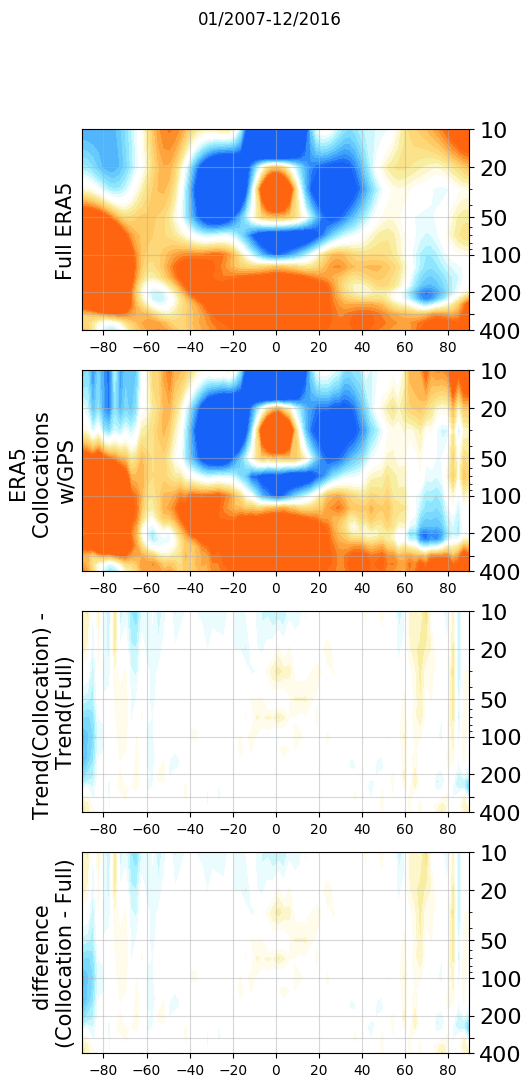

In [12]:
# Fix data to only take trend over 2007 - 2017 time period
ERA5collocationsGPS = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ProfERA5collocationsGPS_2001_2022.npy')[6:16]
ERA5collocationsGPSAnomalies = ERA5collocationsGPS - np.nanmean(ERA5collocationsGPS, axis=0)
ERA5collocationsGPSAnomalies_zm = np.nanmean(ERA5collocationsGPSAnomalies, axis=3)
ERA5collocationsGPSAnomalies_zm_ts = np.reshape(ERA5collocationsGPSAnomalies_zm, (10*12,72,19))
ERA5full = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ERA5ProfMaps_Jan2001_Dec2021.npy')[6:16]
ERA5full = np.flip(ERA5full, axis=3)
ERA5fullAnomalies = ERA5full - np.nanmean(ERA5full, axis=0)
ERA5fullAnomalies_zm = np.nanmean(ERA5fullAnomalies, 4)
ERA5fullAnomalies_zm_ts = np.swapaxes(np.reshape(ERA5fullAnomalies_zm, (10*12,19,72)),1,2)
difference_ts = ERA5collocationsGPSAnomalies_zm_ts - ERA5fullAnomalies_zm_ts
ERA5collocationsTrendMap = Prof_trend_finder(ERA5collocationsGPSAnomalies_zm_ts)[:,:,0]
ERA5FullTrendMap = Prof_trend_finder(ERA5fullAnomalies_zm_ts)[:,:,0]
differenceTrendMap = Prof_trend_finder(difference_ts)[:,:,0]
trenddifference = ERA5collocationsTrendMap - ERA5FullTrendMap

fig, axs = plt.subplots(4,1, figsize=(5,12))
contour_levels = np.arange(-.55,.56,.05)
latitudes = np.linspace(-90,90,72)
plevels = [2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400]
plt.suptitle('01/2007-12/2016')
axs[0].contourf(latitudes, plevels, ERA5FullTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[0].set_ylabel('Full ERA5', fontsize=15)
axs[1].contourf(latitudes, plevels, ERA5collocationsTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[1].set_ylabel('ERA5 \nCollocations \nw/GPS', fontsize=15)
axs[2].contourf(latitudes, plevels, trenddifference.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[2].set_ylabel('Trend(Collocation) - \nTrend(Full)', fontsize=15)
axs[3].contourf(latitudes, plevels, differenceTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[3].set_ylabel('difference \n(Collocation - Full)', fontsize=15)

for i in range(0,4):
    axs[i].set_ylim(axs[i].get_ylim()[::-1])
    #axs[i].set_xticks([-30,-15,0,15,30])
    axs[i].set_yscale('log')
    axs[i].yaxis.tick_right()
    axs[i].grid(alpha=0.5)
    axs[i].set_ylim(400,10)
    axs[i].set_yticks([400, 300, 200, 100, 50, 20, 10])
    axs[i].set_yticklabels(labels=['400',' ','200','100','50','20', '10'], fontsize=16)
    

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


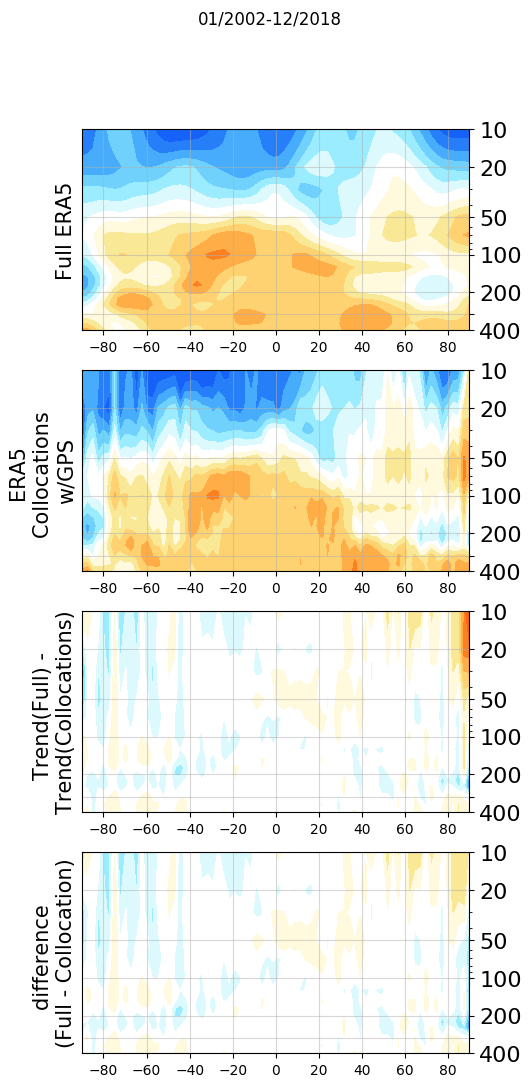

In [6]:
# Fix data to only take trend over 2007 - 2017 time period
ERA5collocationsGPS = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ProfERA5collocationsGPS_2001_2022.npy')[1:19]
ERA5collocationsGPSAnomalies = ERA5collocationsGPS - np.nanmean(ERA5collocationsGPS, axis=0)
ERA5collocationsGPSAnomalies_zm = np.nanmean(ERA5collocationsGPSAnomalies, axis=3)
ERA5collocationsGPSAnomalies_zm_ts = np.reshape(ERA5collocationsGPSAnomalies_zm, (18*12,72,19))
ERA5full = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ERA5ProfMaps_Jan2001_Dec2021.npy')[1:19]
ERA5full = np.flip(ERA5full, axis=3)
ERA5fullAnomalies = ERA5full - np.nanmean(ERA5full, axis=0)
ERA5fullAnomalies_zm = np.nanmean(ERA5fullAnomalies, 4)
ERA5fullAnomalies_zm_ts = np.swapaxes(np.reshape(ERA5fullAnomalies_zm, (18*12,19,72)),1,2)
difference_ts = ERA5collocationsGPSAnomalies_zm_ts - ERA5fullAnomalies_zm_ts
ERA5collocationsTrendMap = Prof_trend_finder(ERA5collocationsGPSAnomalies_zm_ts)[:,:,0]
ERA5FullTrendMap = Prof_trend_finder(ERA5fullAnomalies_zm_ts)[:,:,0]
differenceTrendMap = Prof_trend_finder(difference_ts)[:,:,0]
trenddifference = ERA5collocationsTrendMap - ERA5FullTrendMap

fig, axs = plt.subplots(4,1, figsize=(5,12))
contour_levels = np.arange(-.55,.56,.1)
latitudes = np.linspace(-90,90,72)
plevels = [2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400]
plt.suptitle('01/2002-12/2018')
axs[0].contourf(latitudes, plevels, ERA5FullTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[0].set_ylabel('Full ERA5', fontsize=15)
axs[1].contourf(latitudes, plevels, ERA5collocationsTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[1].set_ylabel('ERA5 \nCollocations \nw/GPS', fontsize=15)
axs[2].contourf(latitudes, plevels, trenddifference.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[2].set_ylabel('Trend(Full) - \nTrend(Collocations)', fontsize=15)
axs[3].contourf(latitudes, plevels, differenceTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[3].set_ylabel('difference \n(Full - Collocation)', fontsize=15)

for i in range(0,4):
    axs[i].set_ylim(axs[i].get_ylim()[::-1])
    #axs[i].set_xticks([-30,-15,0,15,30])
    axs[i].set_yscale('log')
    axs[i].yaxis.tick_right()
    axs[i].grid(alpha=0.5)
    axs[i].set_ylim(400,10)
    axs[i].set_yticks([400, 300, 200, 100, 50, 20, 10])
    axs[i].set_yticklabels(labels=['400',' ','200','100','50','20', '10'], fontsize=16)
    

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


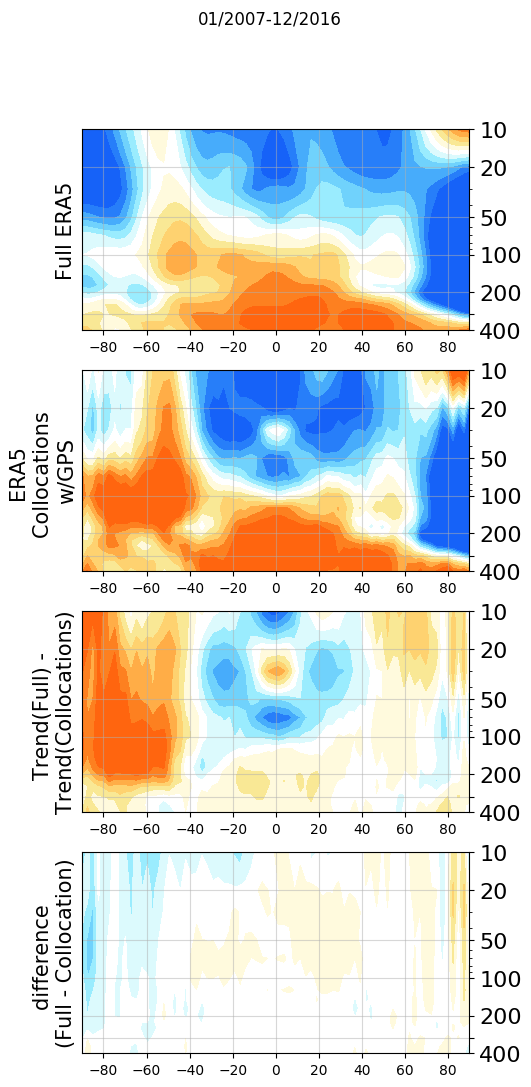

In [8]:
# Fix data to only take trend over 2007 - 2017 time period
ERA5collocationsGPS = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ProfERA5collocationsGPS_2001_2022.npy')[7:-1]
ERA5collocationsGPSAnomalies = ERA5collocationsGPS - np.nanmean(ERA5collocationsGPS, axis=0)
ERA5collocationsGPSAnomalies_zm = np.nanmean(ERA5collocationsGPSAnomalies, axis=3)
ERA5collocationsGPSAnomalies_zm_ts = np.reshape(ERA5collocationsGPSAnomalies_zm, (14*12,72,19))
ERA5full = np.load('/home/bdc2/aodhan/ROM_SAF/Profiles_MonthlyMeanMaps/ERA5ProfMaps_Jan2001_Dec2021.npy')[7:]
ERA5full = np.flip(ERA5full, axis=3)
ERA5fullAnomalies = ERA5full - np.nanmean(ERA5full, axis=0)
ERA5fullAnomalies_zm = np.nanmean(ERA5fullAnomalies, 4)
ERA5fullAnomalies_zm_ts = np.swapaxes(np.reshape(ERA5fullAnomalies_zm, (14*12,19,72)),1,2)
difference_ts = ERA5collocationsGPSAnomalies_zm_ts - ERA5fullAnomalies_zm_ts
ERA5collocationsTrendMap = Prof_trend_finder(ERA5collocationsGPSAnomalies_zm_ts)[:,:,0]
ERA5FullTrendMap = Prof_trend_finder(ERA5fullAnomalies_zm_ts)[:,:,0]
differenceTrendMap = Prof_trend_finder(difference_ts)[:,:,0]
trenddifference = ERA5collocationsTrendMap - ERA5FullTrendMap

fig, axs = plt.subplots(4,1, figsize=(5,12))
contour_levels = np.arange(-.55,.56,.1)
latitudes = np.linspace(-90,90,72)
plevels = [2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400]
plt.suptitle('01/2007-12/2016')
axs[0].contourf(latitudes, plevels, ERA5FullTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[0].set_ylabel('Full ERA5', fontsize=15)
axs[1].contourf(latitudes, plevels, ERA5collocationsTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[1].set_ylabel('ERA5 \nCollocations \nw/GPS', fontsize=15)
axs[2].contourf(latitudes, plevels, trenddifference.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[2].set_ylabel('Trend(Full) - \nTrend(Collocations)', fontsize=15)
axs[3].contourf(latitudes, plevels, differenceTrendMap.T, cmap=custom_cmap, levels=contour_levels, extend='both')
axs[3].set_ylabel('difference \n(Full - Collocation)', fontsize=15)

for i in range(0,4):
    axs[i].set_ylim(axs[i].get_ylim()[::-1])
    #axs[i].set_xticks([-30,-15,0,15,30])
    axs[i].set_yscale('log')
    axs[i].yaxis.tick_right()
    axs[i].grid(alpha=0.5)
    axs[i].set_ylim(400,10)
    axs[i].set_yticks([400, 300, 200, 100, 50, 20, 10])
    axs[i].set_yticklabels(labels=['400',' ','200','100','50','20', '10'], fontsize=16)
    